In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time
%config Completer.use_jedi = False

E:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [65]:
data = pd.read_csv('full_dataset_no_http.csv', index_col=0)
data = data.drop(['author','in_reply_to'], axis = 1)
print("shape:", data.shape)
print("\n")
print("sentiment values: \n", data.sentiment.value_counts())
print("\n")
print('percent of negative: ', (data.sentiment.value_counts()[-1]/data.shape[0]).round(2), '%')
print('percent of positive: ', (data.sentiment.value_counts()[1]/data.shape[0]).round(2), '%')
print('percent of neutral: ', (data.sentiment.value_counts()[0]/data.shape[0]).round(2), '%')

shape: (6504, 2)


sentiment values: 
 -1    4668
 0     977
 1     859
Name: sentiment, dtype: int64


percent of negative:  0.72 %
percent of positive:  0.13 %
percent of neutral:  0.15 %


In [150]:
X = data['text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
word2vec_model = gensim.models.word2vec.KeyedVectors.load_word2vec_format('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-lemmas-restricted-100-skipg-hs.txt.gz', binary=False)

In [43]:
word2vec_model.fill_norms()
word2vec_model.get_normed_vectors()

array([[ 0.04398305, -0.01420086,  0.11561302, ..., -0.15856332,
         0.11655073, -0.11977038],
       [-0.07655355,  0.01751726,  0.08462279, ..., -0.10718547,
         0.16806537, -0.17525007],
       [-0.01108653, -0.03108713,  0.10304717, ..., -0.16802649,
         0.17447282, -0.05389635],
       ...,
       [-0.05141278, -0.00841378,  0.0969136 , ..., -0.01573138,
         0.11124421, -0.0329923 ],
       [ 0.04428269,  0.21340252,  0.06089047, ...,  0.05521889,
         0.03234658,  0.1367556 ],
       [ 0.11268829, -0.03742572,  0.11852093, ...,  0.2335457 ,
         0.01037757,  0.04449902]], dtype=float32)

In [44]:
embedding_matrix = word2vec_model.get_normed_vectors()
print('Shape of embedding matrix: ', embedding_matrix.shape)

Shape of embedding matrix:  (1407762, 100)


In [45]:
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

Found 17060 unique tokens.
{'nie': 1, 'i': 2, 'to': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'do': 9, 'jak': 10, 'jest': 11, 'pan': 12, 'że': 13, 'co': 14, 'o': 15, 'za': 16, 'po': 17, 'tak': 18, 'ale': 19, 'tylko': 20, 'czy': 21, 'dla': 22, 'bo': 23, 'ty': 24, 'już': 25, 'ma': 26, 'od': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'ze': 32, 'tego': 33, 'będzie': 34, 'pana': 35, 'jeszcze': 36, 'są': 37, 'też': 38, 'ten': 39, 'te': 40, 'jesteś': 41, 'gdzie': 42, 'nic': 43, 'teraz': 44, 'sobie': 45, 'no': 46, 'tam': 47, 'ja': 48, 'przez': 49, 'ci': 50, 'być': 51, 'by': 52, 'było': 53, 'nawet': 54, 'trzeba': 55, 'dzieci': 56, 'coś': 57, 'polski': 58, 'kto': 59, 'ich': 60, 'takie': 61, 'was': 62, 'chyba': 63, 'żeby': 64, 'ludzi': 65, 'lat': 66, 'sie': 67, 'bez': 68, 'wy': 69, 'pani': 70, 'tej': 71, 'kiedy': 72, 'można': 73, 'mam': 74, 'u': 75, 'pod': 76, 'był': 77, 'proszę': 78, 'tych': 79, 'mi': 80, 'ludzie': 81, 'mają': 82, 'tu': 83, 'masz': 84, 'bardzo': 85, 'dlaczego': 86, '

In [46]:
batch_size = 32
nb_epoch = 12

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         140776200 
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 140,893,835
Trainable params: 117,635
Non-trainable params: 140,776,200
_________________________________________________________________


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(patience = 4)

In [66]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs = nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val), callbacks=[stop_early])
score = model.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/12
131/131 [==============================] - 16s 94ms/step - loss: 0.7628 - accuracy: 0.7181 - val_loss: 0.7690 - val_accuracy: 0.7233
Epoch 2/12
131/131 [==============================] - 11s 85ms/step - loss: 0.7909 - accuracy: 0.7058 - val_loss: 0.7607 - val_accuracy: 0.7233
Epoch 3/12
131/131 [==============================] - 11s 86ms/step - loss: 0.7602 - accuracy: 0.7193 - val_loss: 0.7594 - val_accuracy: 0.7233
Epoch 4/12
131/131 [==============================] - 11s 85ms/step - loss: 0.7604 - accuracy: 0.7183 - val_loss: 0.7595 - val_accuracy: 0.7233
Epoch 5/12
131/131 [==============================] - 11s 84ms/step - loss: 0.7644 - accuracy: 0.7172 - val_loss: 0.7595 - val_accuracy: 0.7233
Epoch 6/12
33/33 [==============================] - 0s 11ms/step - loss: 0.7665 - accuracy: 0.7262
Test Loss: 76.65%
Test Accuracy: 72.62%


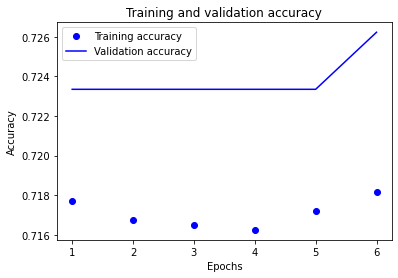

In [69]:
acc = rnn.history['accuracy']
val_acc = rnn.history['val_accuracy']
epochs = range(1,7)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

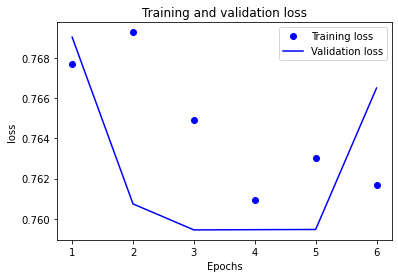

In [70]:
acc = rnn.history['loss']
val_acc = rnn.history['val_loss']
epochs = range(1,7)

plt.plot(epochs, acc, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [72]:
word2vec_model_2 = gensim.models.word2vec.KeyedVectors.load_word2vec_format('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-lemmas-restricted-300-cbow-hs.txt.gz', binary=False)
word2vec_model_2.fill_norms()
word2vec_model_2.get_normed_vectors()

array([[ 0.04227295, -0.04653806,  0.0238421 , ..., -0.02831815,
         0.03205407,  0.02706672],
       [-0.07677276, -0.07749844, -0.07972967, ...,  0.01021889,
         0.00145244,  0.00216667],
       [-0.09345053, -0.11785111, -0.08762265, ...,  0.06044021,
        -0.05273519, -0.04056253],
       ...,
       [ 0.08823415, -0.00642821, -0.02096486, ..., -0.07955194,
         0.00158436,  0.1368946 ],
       [ 0.01479514, -0.00341774,  0.09101544, ..., -0.04654057,
         0.02644729,  0.06470452],
       [ 0.04159387, -0.00111429,  0.0515334 , ...,  0.11518287,
        -0.06412714,  0.07049812]], dtype=float32)

In [74]:
embedding_matrix = word2vec_model_2.get_normed_vectors()
print('Shape of embedding matrix: ', embedding_matrix.shape)

Shape of embedding matrix:  (1407762, 300)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [77]:
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

Found 17060 unique tokens.
{'nie': 1, 'i': 2, 'to': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'do': 9, 'jak': 10, 'jest': 11, 'pan': 12, 'że': 13, 'co': 14, 'o': 15, 'za': 16, 'po': 17, 'tak': 18, 'ale': 19, 'tylko': 20, 'czy': 21, 'dla': 22, 'bo': 23, 'ty': 24, 'już': 25, 'ma': 26, 'od': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'ze': 32, 'tego': 33, 'będzie': 34, 'pana': 35, 'jeszcze': 36, 'są': 37, 'też': 38, 'ten': 39, 'te': 40, 'jesteś': 41, 'gdzie': 42, 'nic': 43, 'teraz': 44, 'sobie': 45, 'no': 46, 'tam': 47, 'ja': 48, 'przez': 49, 'ci': 50, 'być': 51, 'by': 52, 'było': 53, 'nawet': 54, 'trzeba': 55, 'dzieci': 56, 'coś': 57, 'polski': 58, 'kto': 59, 'ich': 60, 'takie': 61, 'was': 62, 'chyba': 63, 'żeby': 64, 'ludzi': 65, 'lat': 66, 'sie': 67, 'bez': 68, 'wy': 69, 'pani': 70, 'tej': 71, 'kiedy': 72, 'można': 73, 'mam': 74, 'u': 75, 'pod': 76, 'był': 77, 'proszę': 78, 'tych': 79, 'mi': 80, 'ludzie': 81, 'mają': 82, 'tu': 83, 'masz': 84, 'bardzo': 85, 'dlaczego': 86, '

In [78]:
batch_size = 32
nb_epoch = 12

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         422328600 
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 422,548,635
Trainable params: 220,035
Non-trainable params: 422,328,600
_________________________________________________________________


In [79]:
stop_early = EarlyStopping(patience = 4)

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs = nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val), callbacks=[stop_early])
score = model.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/12
131/131 [==============================] - 31s 174ms/step - loss: 0.8378 - accuracy: 0.7087 - val_loss: 0.7705 - val_accuracy: 0.7233
Epoch 2/12
131/131 [==============================] - 18s 135ms/step - loss: 0.7586 - accuracy: 0.7269 - val_loss: 0.7756 - val_accuracy: 0.7233
Epoch 3/12
131/131 [==============================] - 17s 132ms/step - loss: 0.7458 - accuracy: 0.7281 - val_loss: 0.7614 - val_accuracy: 0.7233
Epoch 4/12
131/131 [==============================] - 17s 131ms/step - loss: 0.7780 - accuracy: 0.7057 - val_loss: 0.7518 - val_accuracy: 0.7233
Epoch 5/12
131/131 [==============================] - 19s 146ms/step - loss: 0.7499 - accuracy: 0.7150 - val_loss: 0.7567 - val_accuracy: 0.7291
Epoch 6/12
131/131 [==============================] - 20s 154ms/step - loss: 0.7530 - accuracy: 0.7131 - val_loss: 0.7554 - val_accuracy: 0.7281
Epoch 7/12
131/131 [==============================] - 19s 142ms/step - loss: 0.7176 - accuracy: 0.7325 - val_loss: 0.7458 - val_ac

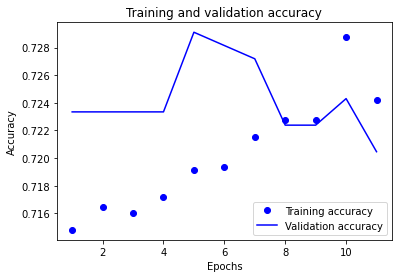

In [82]:
acc = rnn.history['accuracy']
val_acc = rnn.history['val_accuracy']
epochs = range(1,12)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

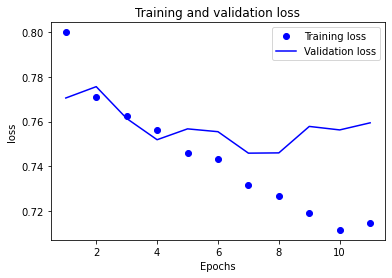

In [83]:
acc = rnn.history['loss']
val_acc = rnn.history['val_loss']
epochs = range(1,12)

plt.plot(epochs, acc, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [89]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import SimpleRNN, Embedding
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers import MaxPool2D, ZeroPadding2D

In [95]:
batch_size = 32
nb_epoch = 12

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

In [119]:
model5 = Sequential()
model5.add(embedding_layer)
model5.add(LSTM(128, recurrent_dropout=0.3, dropout=0.3))
model.add(BatchNormalization())

model5.add(embedding_layer)
model5.add(LSTM(128, recurrent_dropout=0.3, dropout=0.3))
model.add(BatchNormalization())

model5.add(embedding_layer)
model5.add(LSTM(128, recurrent_dropout=0.3, dropout=0.3))
model.add(BatchNormalization())

model5.add(Dense(nb_classes))
model5.add(Activation('softmax'))
model5.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  422328600 
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               219648    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               219648    
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_7 (Activation)    (None, 3)                 0         
Total params: 422,987,931
Trainable params: 659,331
Non-trainable params: 422,328,600
_________________________________

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [156]:
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

Found 17060 unique tokens.
{'nie': 1, 'i': 2, 'to': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'do': 9, 'jak': 10, 'jest': 11, 'pan': 12, 'że': 13, 'co': 14, 'o': 15, 'za': 16, 'po': 17, 'tak': 18, 'ale': 19, 'tylko': 20, 'czy': 21, 'dla': 22, 'bo': 23, 'ty': 24, 'już': 25, 'ma': 26, 'od': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'ze': 32, 'tego': 33, 'będzie': 34, 'pana': 35, 'jeszcze': 36, 'są': 37, 'też': 38, 'ten': 39, 'te': 40, 'jesteś': 41, 'gdzie': 42, 'nic': 43, 'teraz': 44, 'sobie': 45, 'no': 46, 'tam': 47, 'ja': 48, 'przez': 49, 'ci': 50, 'być': 51, 'by': 52, 'było': 53, 'nawet': 54, 'trzeba': 55, 'dzieci': 56, 'coś': 57, 'polski': 58, 'kto': 59, 'ich': 60, 'takie': 61, 'was': 62, 'chyba': 63, 'żeby': 64, 'ludzi': 65, 'lat': 66, 'sie': 67, 'bez': 68, 'wy': 69, 'pani': 70, 'tej': 71, 'kiedy': 72, 'można': 73, 'mam': 74, 'u': 75, 'pod': 76, 'był': 77, 'proszę': 78, 'tych': 79, 'mi': 80, 'ludzie': 81, 'mają': 82, 'tu': 83, 'masz': 84, 'bardzo': 85, 'dlaczego': 86, '

In [122]:
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model5.fit(X_train, y_train, epochs = nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val), callbacks=[stop_early])
score = model5.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/12
131/131 [==============================] - 74s 520ms/step - loss: 0.8274 - accuracy: 0.6932 - val_loss: 0.7820 - val_accuracy: 0.7233
Epoch 2/12
131/131 [==============================] - 69s 530ms/step - loss: 0.7845 - accuracy: 0.7260 - val_loss: 0.7850 - val_accuracy: 0.7233
Epoch 3/12
131/131 [==============================] - 67s 511ms/step - loss: 0.7886 - accuracy: 0.7200 - val_loss: 0.7828 - val_accuracy: 0.7233
Epoch 4/12
131/131 [==============================] - 67s 514ms/step - loss: 0.7977 - accuracy: 0.7154 - val_loss: 0.7820 - val_accuracy: 0.7233
Epoch 5/12
131/131 [==============================] - 67s 514ms/step - loss: 0.7955 - accuracy: 0.7155 - val_loss: 0.7816 - val_accuracy: 0.7233
Epoch 6/12
131/131 [==============================] - 67s 514ms/step - loss: 0.8084 - accuracy: 0.7077 - val_loss: 0.7812 - val_accuracy: 0.7233
Epoch 7/12
131/131 [==============================] - 67s 512ms/step - loss: 0.7834 - accuracy: 0.7234 - val_loss: 0.7802 - val_ac

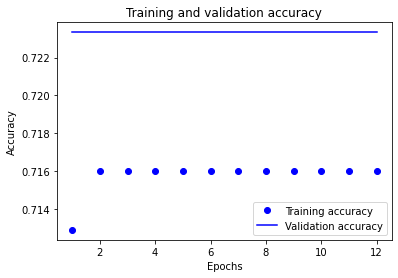

In [124]:
acc = rnn.history['accuracy']
val_acc = rnn.history['val_accuracy']
epochs = range(1,13)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

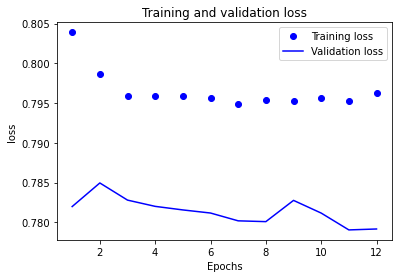

In [125]:
acc = rnn.history['loss']
val_acc = rnn.history['val_loss']
epochs = range(1,13)

plt.plot(epochs, acc, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [135]:
clf=RandomForestClassifier(n_estimators=320)

In [136]:
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [137]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6856264411990777


In [138]:
from sklearn.ensemble import GradientBoostingClassifier

In [139]:
gbc=RandomForestClassifier(n_estimators=320)

In [143]:
gbc.fit(X_train,y_train)

y_pred=gbc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6810146041506533


In [141]:
from xgboost import XGBClassifier

In [157]:
from sklearn.neighbors import KNeighborsClassifier

In [166]:
from sklearn.model_selection import GridSearchCV

In [172]:
knc = KNeighborsClassifier()
knc.fit(X_train,y_train)

KNeighborsClassifier()

In [174]:
param_grid = {'n_neighbors': [0,1,2,5,8,10,12,15]}  
   
grid = GridSearchCV(knc, param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished


{'n_neighbors': 15}


NameError: name 'classification_report' is not defined

In [176]:
knc = KNeighborsClassifier(n_neighbors = 15)

In [177]:
knc.fit(X_train,y_train)

y_pred=knc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.633358954650269
